In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
headers = ['age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'gpa', 'SAT', 'SATWriting', 'APTests', 'APScores', 'STEM', 'essays', 'extracurriculars', 'percentile', 'collegeLevel', 'collegeScore', 'accepted']
header_type = [int, bool, bool,    bool,    bool,    bool,       bool,       float,  int,    float,       int,       float,      bool,   float,    int,               float,         int,              float,        bool]

In [ ]:
print(len(headers), len(header_type))

19 19


In [ ]:
def collegeScore(person):
    # soft max score 1000
    score = 0
    applicant = {}
    for i in range(len(headers)):
        applicant[headers[i]] = person[i]
    if applicant['collegeLevel'] == 0:
        score += applicant['gpa']/4*250
        score += (applicant['SAT']-800)/800 * 50
        score += (applicant['SATWriting'])/8 * 50
        score += applicant['extracurriculars']/8 * 250
        score += applicant['essays'] * 300
        score += applicant['APTests']*applicant['APScores']/5*100
        if not applicant['white']:
            score *= 1.15

    if applicant['collegeLevel'] == 1:
        score += applicant['gpa']/4*250
        score += (applicant['SAT']-800)/800 * 150
        score += (applicant['SATWriting'])/8 * 100
        score += applicant['extracurriculars']/8 * 150
        score += applicant['essays'] * 200
        score += applicant['APTests']*applicant['APScores']/5*150
        if not applicant['white'] and not applicant['asian']:
            score *= 1.1

    if applicant['collegeLevel'] == 2:
        score += applicant['gpa']/4.5*200
        score += (applicant['SAT']-1200)/400 * 200
        score += (applicant['SATWriting']-4)/4 * 100
        score += applicant['extracurriculars']/8 * 100
        score += applicant['essays'] * 200
        score += applicant['APTests']*(applicant['APScores']-3)/2/10*200
        if applicant['gpa'] < 3.0:
            score = 0

    if applicant['collegeLevel'] == 3:
        score += 2**(3*(applicant['gpa']-5))*200
        score += 2**(3*(applicant['SAT']-1600)/100) * 150
        score += (applicant['SATWriting']-7) * 75
        score += 2**(1.7*(applicant['extracurriculars']/15-1)) * 175
        score += 2**(1.7*(applicant['essays']-1)) * 300
        score += applicant['APTests']*(applicant['APScores']-4)/10*100
        if applicant['gpa'] < 4.0 or (applicant['SAT'] < 1500 and applicant['STEM']):
            score = 0

    score = np.random.normal(score, 50, 1)[0]
    return score




In [ ]:
def personGenerator(percentile):
    person = np.zeros(len(headers))
    age = random.randint(16,18)
    person[0] = age
    sex = random.randint(0,1)
    person[1] = sex
    race_index = np.random.choice([0,1,2,3,4], 1,
              p=[0.5, 0.2, 0.1, 0.1, 0.1]) + 2
    person[race_index] = 1

    gpa = -1
    SAT = -1
    SATWriting = -1
    APTests = -1
    APScores = -1
    STEM = -1
    essays= -1
    extracurriculars = -1
    collegeLevel = -1
    if percentile > 0.99:
        gpa = 4.0 + (percentile-0.98) * 100/2 * random.random()
        SAT = 1550 + round(min(50,(percentile-0.98) * 100 * random.random() * 50))
        SATWriting = 6 + (min(2, (percentile-0.98) * 100 * random.random() * 2))
        APTests = 4 + round(8*random.random())
        APScores = 4 + min(1,random.random()*(percentile-0.99)*100*2)
        STEM = random.random()+0.2
        essays = percentile + (1-percentile)*((random.random()*2)-1)
        extracurriculars = 3 + round(np.random.normal((percentile-0.98) * 1000/3, 2, 1)[0])
        collegeLevel = 3
    elif percentile > 0.9:
        gpa = 3.5 + (percentile-0.80) * 10/2 * random.random()
        SAT = min(1600, np.random.normal((percentile*1600), 1600*(1-percentile)/4, 1)[0])
        SATWriting = 5 + (min(3, (percentile-0.8) * 10 * random.random() * 2))
        APTests = 3 + round(6*random.random())
        APScores = 4 + min(1,random.random()*(percentile-0.85)*10*2) * 1
        STEM = random.random()+0.1
        essays = percentile + (1-percentile)*((random.random()*2)-1)
        extracurriculars = 2 + round(np.random.normal((percentile-0.80) * 100/4, 2, 1)[0])
        collegeLevel = 2
    elif percentile > 0.7:
        gpa = 3.6 + np.random.normal((percentile-0.80)*2, 0.15, 1)[0]
        SAT = min(1600, np.random.normal((800+percentile*800), 1600*0.15/4, 1)[0])
        SATWriting = 5 + (min(3, (percentile-0.8) * 10 * random.random() * 2))
        APTests = 1 + round(np.random.normal((percentile-0.7)*10, 1, 1)[0])
        APScores = 3 + min(1,random.random()*(percentile-0.7)*10) * 1
        STEM = random.random()
        essays = percentile + (1-percentile)*((random.random()*2)-1)
        extracurriculars = 1 + round(np.random.normal((percentile-0.70) * 100/4, 1.5, 1)[0])
        collegeLevel = 1
    else:
        gpa = 2 + np.random.normal(percentile*2, 0.6*(percentile+0.4)/2, 1)[0]
        SAT = min(1600, np.random.normal((800+percentile*800), 1600*0.15/4, 1)[0])
        SATWriting = 2 + (min(6, (percentile) * 10 * random.random()))
        APTests = round(np.random.normal((percentile)*10/6, 0.35, 1)[0])
        APScores = min(5,(np.random.normal(3+(percentile-0.4)*10/5, 0.35, 1)[0]))
        STEM = random.random()-0.2
        essays = percentile + min(percentile,(1-percentile))*((random.random()*2)-1)
        extracurriculars = round(max(0,np.random.normal((percentile) * 10/6, 1, 1)[0]))
        collegeLevel = 0

    person[7] = gpa
    person[8] = SAT
    person[9] = SATWriting
    person[10] = APTests
    person[11] = APScores
    # print(STEM)
    person[12] = min(1,max(0,(STEM + 0.15*person[1] + -0.15*((person[1]+1)%2) + 0.2*person[3] + -0.2*person[4] -0.1*person[5])-0.25))
    # print(person[1], person[3], person[4], person[5])
    # print(person[12])
    person[12] = round(person[12])
    # if person[12] == 0:
    #     print(person)
    person[13] = essays
    person[14] = extracurriculars

    person[15] = percentile

    applications = None
    if collegeLevel in (0,3):
        applications = np.tile(person, (2, 1))
        applications[0,-3] = collegeLevel
        if collegeLevel == 0:
            applications[1,-3] = collegeLevel + 1
        else:
            applications[1,-3] = collegeLevel - 1
    else:
        applications = np.tile(person, (3, 1))
        applications[0,-3] = collegeLevel
        applications[1,-3] = collegeLevel+1
        applications[2,-3] = collegeLevel-1
    for application in applications:
        application[-2] = collegeScore(application)
    return applications


In [ ]:
def applicationCutOff(applicants):
    college0CutOff = np.percentile(applicants[np.in1d(applicants[:, -3], [0])][:,-2],20)
    college1CutOff = np.percentile(applicants[np.in1d(applicants[:, -3], [1])][:,-2],50)
    return college0CutOff, college1CutOff

def accepted(applicants):
    final_applicants = np.empty((0,applicants.shape[1]))
    college0CutOff, college1CutOff = applicationCutOff(applicants)
    print(college0CutOff, college1CutOff)
    college0Applicants = applicants[np.in1d(applicants[:, -3], [0])]
    college0Applicants[:,-1] = college0Applicants[:,-2] > college0CutOff
    college1Applicants = applicants[np.in1d(applicants[:, -3], [1])]
    college1Applicants[:,-1] = college1Applicants[:,-2] > college1CutOff
    final_applicants = np.append(college0Applicants, college1Applicants, axis=0)

    college2Applicants = applicants[np.in1d(applicants[:, -3], [2])]
    college2ApplicantsNonSTEM = college2Applicants[np.in1d(college2Applicants[:, 12], [0])]
    college2ApplicantsNonSTEMCutOff = np.percentile(college2ApplicantsNonSTEM[:,-2],70)
    college2ApplicantsNonSTEM[:,-1] = college2ApplicantsNonSTEM[:,-2]>college2ApplicantsNonSTEMCutOff

    college2ApplicantsSTEM = college2Applicants[np.in1d(college2Applicants[:, 12], [1])]
    college2ApplicantsSTEMCount = college2ApplicantsSTEM.shape[0]
    college2ApplicantsSTEMMinorityCount = int(college2ApplicantsSTEMCount*0.15*0.25)
    college2ApplicantsSTEMMajorityCount = int(college2ApplicantsSTEMCount*0.15*0.75)
    college2ApplicantsSTEMMinority = college2ApplicantsSTEM[((college2ApplicantsSTEM[:,2] == 0) & (college2ApplicantsSTEM[:,3] == 0))]
    college2ApplicantsSTEMMinority = college2ApplicantsSTEMMinority[college2ApplicantsSTEMMinority[:,-2].argsort()]
    college2ApplicantsSTEMMajority = college2ApplicantsSTEM[((college2ApplicantsSTEM[:,2] == 1) | (college2ApplicantsSTEM[:,3] == 1))]
    college2ApplicantsSTEMMajority = college2ApplicantsSTEMMajority[college2ApplicantsSTEMMajority[:,-2].argsort()]
    college2ApplicantsSTEMMinority[-college2ApplicantsSTEMMinorityCount:,-1] = 1
    college2ApplicantsSTEMMajority[-college2ApplicantsSTEMMajorityCount:,-1] = 1

    final_applicants = np.append(final_applicants, college2ApplicantsNonSTEM, axis=0)
    final_applicants = np.append(final_applicants, college2ApplicantsSTEMMinority, axis=0)
    final_applicants = np.append(final_applicants, college2ApplicantsSTEMMajority, axis=0)

    college3Applicants = applicants[np.in1d(applicants[:, -3], [3])]
    college3ApplicantsNonSTEM = college3Applicants[np.in1d(college3Applicants[:, 12], [0])]
    college3ApplicantsNonSTEMCount = college3ApplicantsNonSTEM.shape[0]
    college3ApplicantsNonSTEMMinorityCount = int(college3ApplicantsNonSTEMCount*0.1*0.25)
    college3ApplicantsNonSTEMMajorityCount = int(college3ApplicantsNonSTEMCount*0.1*0.75)
    college3ApplicantsNonSTEMMinority = college3ApplicantsNonSTEM[(college3ApplicantsNonSTEM[:,1] == 0) | ((college3ApplicantsNonSTEM[:,2] == 0) & (college3ApplicantsNonSTEM[:,3] == 0))]
    college3ApplicantsNonSTEMMinority = college3ApplicantsNonSTEMMinority[college3ApplicantsNonSTEMMinority[:,-2].argsort()]
    college3ApplicantsNonSTEMMajority = college3ApplicantsNonSTEM[(college3ApplicantsNonSTEM[:,1] == 1) & ((college3ApplicantsNonSTEM[:,2] == 1) | (college3ApplicantsNonSTEM[:,3] == 1))]
    college3ApplicantsNonSTEMMajority = college3ApplicantsNonSTEMMajority[college3ApplicantsNonSTEMMajority[:,-2].argsort()]
    college3ApplicantsNonSTEMMinority[-college3ApplicantsNonSTEMMinorityCount:,-1] = 1
    college3ApplicantsNonSTEMMajority[-college3ApplicantsNonSTEMMajorityCount:,-1] = 1

    college3ApplicantsSTEM = college3Applicants[np.in1d(college3Applicants[:, 12], [1])]
    college3ApplicantsSTEMCount = college3ApplicantsSTEM.shape[0]
    college3ApplicantsSTEMMinorityCount = int(college3ApplicantsSTEMCount*0.05*0.25)
    college3ApplicantsSTEMMajorityCount = int(college3ApplicantsSTEMCount*0.05*0.75)
    college3ApplicantsSTEMMinority = college3ApplicantsSTEM[((college3ApplicantsSTEM[:,2] == 0) & (college3ApplicantsSTEM[:,3] == 0))]
    college3ApplicantsSTEMMinority = college3ApplicantsSTEMMinority[college3ApplicantsSTEMMinority[:,-2].argsort()]
    college3ApplicantsSTEMMajority = college3ApplicantsSTEM[((college3ApplicantsSTEM[:,2] == 1) | (college3ApplicantsSTEM[:,3] == 1))]
    college3ApplicantsSTEMMajority = college3ApplicantsSTEMMajority[college3ApplicantsSTEMMajority[:,-2].argsort()]
    college3ApplicantsSTEMMinority[-college3ApplicantsSTEMMinorityCount:,-1] = 1
    college3ApplicantsSTEMMajority[-college3ApplicantsSTEMMajorityCount:,-1] = 1
    print((np.sum(college3ApplicantsSTEMMinority[:,-1])+np.sum(college3ApplicantsSTEMMajority[:,-1]))/college3ApplicantsSTEMCount)

    final_applicants = np.append(final_applicants, college3ApplicantsNonSTEMMinority, axis=0)
    final_applicants = np.append(final_applicants, college3ApplicantsNonSTEMMajority, axis=0)
    final_applicants = np.append(final_applicants, college3ApplicantsSTEMMinority, axis=0)
    final_applicants = np.append(final_applicants, college3ApplicantsSTEMMajority, axis=0)

    return final_applicants

In [ ]:
n = int(10001)
applicants = np.empty((0,len(headers)))
applicants_temp = np.empty((0,len(headers)))
applicants_temp_temp = np.empty((0,len(headers)))
for i in range(n):
    applicants_temp_temp = np.append(applicants_temp_temp, personGenerator(i/n/4*3+0.25), axis=0)
    if i%100000==0:
        applicants = np.append(applicants, applicants_temp, axis=0)
        applicants_temp = np.empty((0,len(headers)))
    if i%10000 == 0:
        applicants_temp = np.append(applicants_temp, applicants_temp_temp, axis=0)
        applicants_temp_temp = np.empty((0,len(headers)))
        print(i)
applicants_temp = np.append(applicants_temp, applicants_temp_temp, axis=0)
applicants = np.append(applicants, applicants_temp, axis=0)

print(applicants.shape)
applicants = accepted(applicants)



0
10000
(23869, 19)
462.2893893799057 680.9471678684561
0.046908315565031986


In [ ]:
for j in range(30):
    temp = {}
    for i in range(len(headers)):
        temp[headers[i]] = applicants[22750+j, i]
    print(temp)

{'age': 17.0, 'sex': 0.0, 'white': 1.0, 'asian': 0.0, 'black': 0.0, 'hispanic': 0.0, 'otherRace': 0.0, 'gpa': 3.8742872081177633, 'SAT': 1575.7337660840171, 'SATWriting': 6.450994228317285, 'APTests': 6.0, 'APScores': 4.859607274914069, 'STEM': 0.0, 'essays': 0.9990616091288076, 'extracurriculars': 5.0, 'percentile': 0.9829767023297671, 'collegeLevel': 3.0, 'collegeScore': 4.913293266719709, 'accepted': 0.0}
{'age': 17.0, 'sex': 1.0, 'white': 0.0, 'asian': 0.0, 'black': 0.0, 'hispanic': 0.0, 'otherRace': 1.0, 'gpa': 3.636126846660924, 'SAT': 1513.1980029012516, 'SATWriting': 5.8161540564279655, 'APTests': 6.0, 'APScores': 4.113670441529083, 'STEM': 0.0, 'essays': 0.8913536709367436, 'extracurriculars': 4.0, 'percentile': 0.9080591940805919, 'collegeLevel': 3.0, 'collegeScore': 5.337851702101415, 'accepted': 0.0}
{'age': 18.0, 'sex': 0.0, 'white': 0.0, 'asian': 0.0, 'black': 0.0, 'hispanic': 1.0, 'otherRace': 0.0, 'gpa': 3.6073760226776526, 'SAT': 1554.1896509540952, 'SATWriting': 6.377

In [ ]:
applicants_final = applicants[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,18]]
headers_final = ['age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'gpa', 'SAT', 'SATWriting', 'APTests', 'APScores', 'STEM', 'essays', 'extracurriculars', 'collegeLevel', 'accepted']
df = pd.DataFrame(applicants_final, columns=headers_final)
df.to_csv("college_acceptance_"+ str(n) +"_gaussian.csv")

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)
fn = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive/


In [ ]:
applicants_final = pd.read_csv(fn+"college_acceptance_10000.csv").values[:-1,:]

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/college_acceptance_racist_sexist_10000.csv'

In [ ]:
X = applicants_final[:,:-1]
y = applicants_final[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [ ]:
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [ ]:
def build_model():
    model = Sequential()
    model.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Add layers here
    return model

model = build_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                540       
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1181 (4.61 KB)
Trainable params: 1181 (4.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Play around with these values

# Try using SGD(learning_rate=lr) or Adam(learning_rate=lr)
optimizer = Adam(learning_rate=0.001)

# Try using 'mean_squared_error' or 'binary_crossentropy'
loss = 'binary_crossentropy'

metrics = 'accuracy'

# The higher you set this the longer it takes to train (start with 20)
epochs = 50

# Compiles the model
model.compile(optimizer = optimizer, metrics = metrics, loss = loss)

# Trains the model
hist = model.fit(X_train, y_train, epochs = epochs, batch_size=100)

Epoch 1/50
    1/14490 [..............................] - ETA: 3:31:45 - loss: 0.3612 - accuracy: 0.8700

KeyboardInterrupt: ignored

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy: ", accuracy)
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'])
    plt.show()

def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train'])
    plt.show()

plot_losses(hist)
plot_accuracies(hist)

In [ ]:
# clf = tree.DecisionTreeClassifier()
# clf = LogisticRegression(random_state=0)
clf = SVC(kernel="linear", C=0.025, random_state=42)
# clf = SVC(gamma=2, C=1, random_state=42)
# clf = RandomForestClassifier(random_state=42)
clf = clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7451388967167525


<Figure size 1400x1400 with 0 Axes>

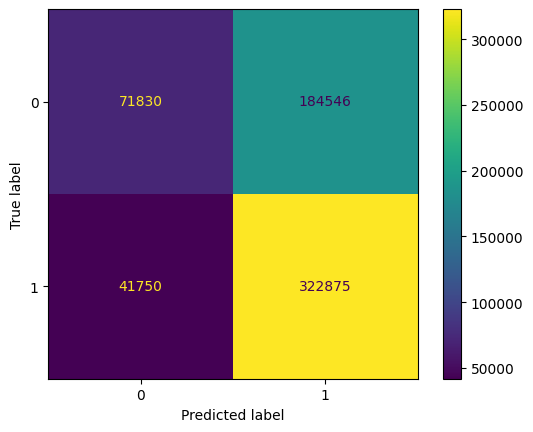

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(14,14))
disp.plot()
plt.show()

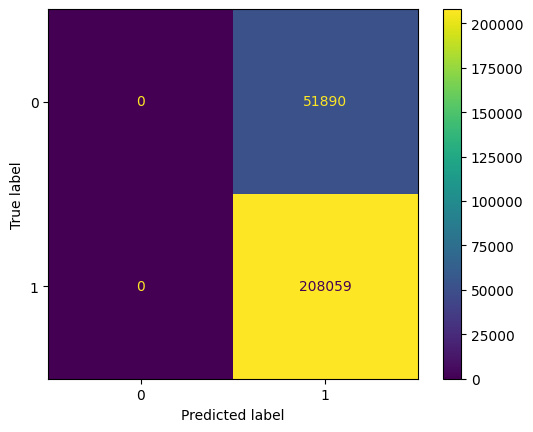

In [ ]:
y_test0 = y_test[np.in1d(X_test[:, -1], [0])]
y_pred0 = y_pred[np.in1d(X_test[:, -1], [0])]
cm = confusion_matrix(y_test0, y_pred0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

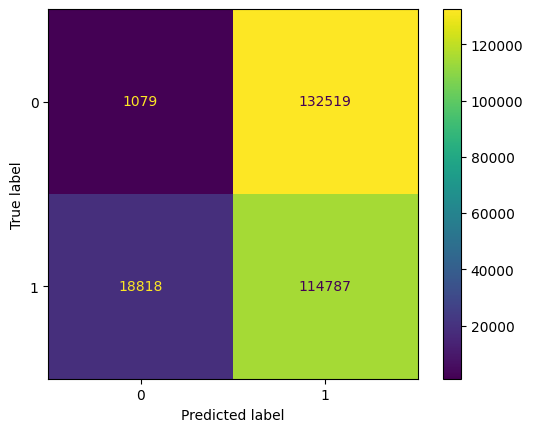

In [ ]:
y_test1 = y_test[np.in1d(X_test[:, -1], [1])]
y_pred1 = y_pred[np.in1d(X_test[:, -1], [1])]
cm = confusion_matrix(y_test1, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

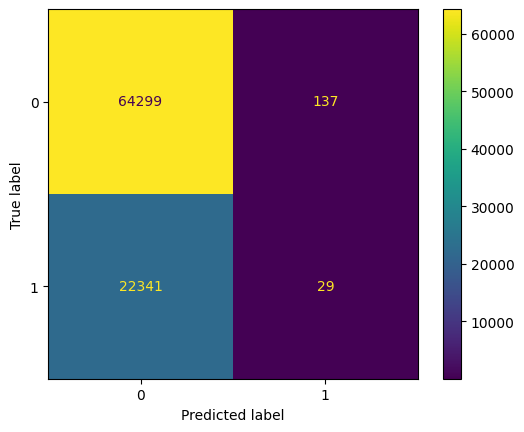

In [ ]:
y_test2 = y_test[np.in1d(X_test[:, -1], [2])]
y_pred2 = y_pred[np.in1d(X_test[:, -1], [2])]
cm = confusion_matrix(y_test2, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

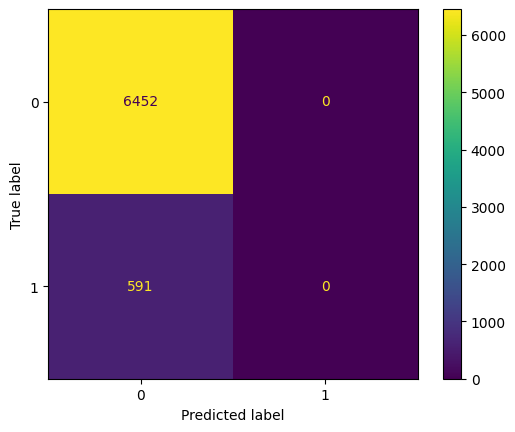

In [ ]:
y_test3 = y_test[np.in1d(X_test[:, -1], [3])]
y_pred3 = y_pred[np.in1d(X_test[:, -1], [3])]
cm = confusion_matrix(y_test3, y_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# plt.figure(figsize=(400,14))
# tree.plot_tree(clf, max_depth=8,fontsize=7, feature_names=headers_final)
# plt.savefig('tree_high_dpi', dpi=100)